<a href="https://colab.research.google.com/github/adunStudio/hanghae99_plusAI_2/blob/main/1%EC%A3%BC%EC%B0%A8/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [FEEDBACK] 맥 환경입니다. CUDA가 아닌 MPS 사용해도 될까요?

| **항목**          | **CUDA**                                  | **MPS (Metal Performance Shaders)**        |
|-------------------|------------------------------------------|-------------------------------------------|
| **제작사**       | NVIDIA                                   | Apple                                     |
| **호환 하드웨어** | NVIDIA GPU 전용                         | Apple Silicon (M1, M2), 일부 Intel Mac GPU |
| **플랫폼**       | Windows, Linux, macOS (NVIDIA GPU만)     | macOS 및 iOS                              |
| **프로그래밍 모델** | CUDA C/C++, Python, cuDNN 등 지원       | Metal API 기반, Python (PyTorch MPS)       |
| **프레임워크 호환성** | TensorFlow, PyTorch, MXNet, etc.         | PyTorch (MPS 백엔드)                      |
| **생태계**       | 매우 광범위, NVIDIA GPU 생태계에 집중    | Apple 생태계 내에 한정                    |
| **API 및 라이브러리** | CUDA Core, cuDNN, cuBLAS, TensorRT 등    | Metal Performance Shaders API             |

In [11]:
import torch
print(f"MPS 장치를 지원하도록 build가 되었는가? {torch.backends.mps.is_built()}")
print(f"MPS 장치가 사용 가능한가? {torch.backends.mps.is_available()}")

device = torch.device("mps")

MPS 장치를 지원하도록 build가 되었는가? True
MPS 장치가 사용 가능한가? True


# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

# [MY CODE] Test data 준비하기 1/2


In [13]:
# 데이터셋 전처리:
# 1. PIL 이미지 또는 NumPy 배열 → PyTorch Tensor로 변환
# 2. 이미지를 Tensor로 변환 (픽셀 값을 [0, 1] 범위로 정규화)
transform = transforms.ToTensor()

# MNIST 학습 데이터셋 로드
train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

# MNIST 테스트 데이터셋 로드
test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


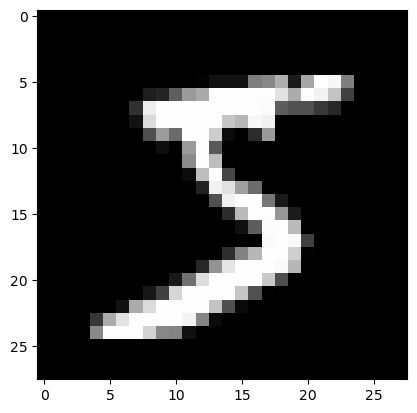

In [14]:
from matplotlib import pyplot as plt

print(len(train_set))
print(train_set[0][0].shape, train_set[0][1])
plt.imshow(train_set[0][0][0], cmap='gray')
# 60,000개의 이미지로 구성되어있다.
# [1, 28, 28]: 1채널(흑백), 28 x 28 크기 이미지

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

# [MY CODE] Test data 준비하기 2/2


In [15]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [16]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [17]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [18]:
from torch import nn


class Model(nn.Module):
    def __init__(self, input_dim, num_dim, num_classes):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, num_dim)
        self.layer2 = nn.Linear(num_dim, num_dim)
        self.layer3 = nn.Linear(num_dim, num_classes)  # 최종 출력 레이어

        self.act = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # 입력 평탄화
        x = self.act(self.layer1(x))       # 첫 번째 레이어 + ReLU
        x = self.act(self.layer2(x))       # 두 번째 레이어 + ReLU
        x = self.layer3(x)                 # 세 번째 레이어 (로짓 반환)
        # CrossEntropyLoss는 Softmax를 내부적으로 자동 적용한다.
        return x


model = Model(28 * 28 * 1, 1024, 10)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

# [MY CODE] nn.CrossEntropyLoss 적용하기

In [19]:
from torch.optim import SGD

lr = 0.001
model = model.to(device)

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

optimizer = SGD(model.parameters(), lr=lr)

train_accuracies = []
test_accuracies = []

이전 코드와 거의 똑같습니다. 다른 점은 `model.to(device)` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [20]:
import time

num_epochs = 100

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  model.eval()  # 평가 모드
  with torch.no_grad():
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {total_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 3.08 seconds | Loss: 538.81 | Train Acc: 0.269 | Test Acc: 0.271
Epoch   2 | Time: 2.59 seconds | Loss: 534.96 | Train Acc: 0.323 | Test Acc: 0.327
Epoch   3 | Time: 2.57 seconds | Loss: 531.01 | Train Acc: 0.371 | Test Acc: 0.379
Epoch   4 | Time: 2.62 seconds | Loss: 526.83 | Train Acc: 0.429 | Test Acc: 0.443
Epoch   5 | Time: 2.58 seconds | Loss: 522.30 | Train Acc: 0.494 | Test Acc: 0.505
Epoch   6 | Time: 2.80 seconds | Loss: 517.27 | Train Acc: 0.548 | Test Acc: 0.561
Epoch   7 | Time: 2.56 seconds | Loss: 511.63 | Train Acc: 0.591 | Test Acc: 0.599
Epoch   8 | Time: 2.55 seconds | Loss: 505.27 | Train Acc: 0.626 | Test Acc: 0.633
Epoch   9 | Time: 2.58 seconds | Loss: 497.96 | Train Acc: 0.653 | Test Acc: 0.661
Epoch  10 | Time: 2.58 seconds | Loss: 489.56 | Train Acc: 0.674 | Test Acc: 0.680
Epoch  11 | Time: 2.61 seconds | Loss: 479.91 | Train Acc: 0.693 | Test Acc: 0.699
Epoch  12 | Time: 2.67 seconds | Loss: 468.84 | Train Acc: 0.707 | Test Acc: 0.714
Epoc

# [LOG] 학습 과정에서의 Epoch별 손실값 출력

```
Epoch   1 | Time: 3.08 seconds | Loss: 538.81 | Train Acc: 0.269 | Test Acc: 0.271
Epoch   2 | Time: 2.59 seconds | Loss: 534.96 | Train Acc: 0.323 | Test Acc: 0.327
Epoch   3 | Time: 2.57 seconds | Loss: 531.01 | Train Acc: 0.371 | Test Acc: 0.379
Epoch   4 | Time: 2.62 seconds | Loss: 526.83 | Train Acc: 0.429 | Test Acc: 0.443
Epoch   5 | Time: 2.58 seconds | Loss: 522.30 | Train Acc: 0.494 | Test Acc: 0.505
Epoch   6 | Time: 2.80 seconds | Loss: 517.27 | Train Acc: 0.548 | Test Acc: 0.561
Epoch   7 | Time: 2.56 seconds | Loss: 511.63 | Train Acc: 0.591 | Test Acc: 0.599
Epoch   8 | Time: 2.55 seconds | Loss: 505.27 | Train Acc: 0.626 | Test Acc: 0.633
Epoch   9 | Time: 2.58 seconds | Loss: 497.96 | Train Acc: 0.653 | Test Acc: 0.661
Epoch  10 | Time: 2.58 seconds | Loss: 489.56 | Train Acc: 0.674 | Test Acc: 0.680
Epoch  11 | Time: 2.61 seconds | Loss: 479.91 | Train Acc: 0.693 | Test Acc: 0.699
Epoch  12 | Time: 2.67 seconds | Loss: 468.84 | Train Acc: 0.707 | Test Acc: 0.714
Epoch  13 | Time: 2.71 seconds | Loss: 456.17 | Train Acc: 0.718 | Test Acc: 0.727
Epoch  14 | Time: 2.60 seconds | Loss: 441.89 | Train Acc: 0.728 | Test Acc: 0.736
Epoch  15 | Time: 2.60 seconds | Loss: 425.93 | Train Acc: 0.734 | Test Acc: 0.742
Epoch  16 | Time: 2.60 seconds | Loss: 408.42 | Train Acc: 0.739 | Test Acc: 0.748
Epoch  17 | Time: 2.61 seconds | Loss: 389.64 | Train Acc: 0.745 | Test Acc: 0.753
Epoch  18 | Time: 2.61 seconds | Loss: 369.97 | Train Acc: 0.749 | Test Acc: 0.758
Epoch  19 | Time: 2.59 seconds | Loss: 349.80 | Train Acc: 0.755 | Test Acc: 0.765
Epoch  20 | Time: 2.64 seconds | Loss: 329.83 | Train Acc: 0.763 | Test Acc: 0.772
Epoch  21 | Time: 2.57 seconds | Loss: 310.51 | Train Acc: 0.770 | Test Acc: 0.780
Epoch  22 | Time: 2.60 seconds | Loss: 292.24 | Train Acc: 0.779 | Test Acc: 0.787
Epoch  23 | Time: 2.59 seconds | Loss: 275.34 | Train Acc: 0.786 | Test Acc: 0.794
Epoch  24 | Time: 2.61 seconds | Loss: 259.80 | Train Acc: 0.792 | Test Acc: 0.800
Epoch  25 | Time: 2.70 seconds | Loss: 245.80 | Train Acc: 0.799 | Test Acc: 0.804
Epoch  26 | Time: 2.64 seconds | Loss: 233.12 | Train Acc: 0.804 | Test Acc: 0.812
Epoch  27 | Time: 2.61 seconds | Loss: 221.75 | Train Acc: 0.808 | Test Acc: 0.815
Epoch  28 | Time: 2.60 seconds | Loss: 211.64 | Train Acc: 0.813 | Test Acc: 0.821
Epoch  29 | Time: 2.59 seconds | Loss: 202.47 | Train Acc: 0.818 | Test Acc: 0.824
Epoch  30 | Time: 2.60 seconds | Loss: 194.10 | Train Acc: 0.822 | Test Acc: 0.829
Epoch  31 | Time: 2.61 seconds | Loss: 186.73 | Train Acc: 0.826 | Test Acc: 0.832
Epoch  32 | Time: 2.58 seconds | Loss: 180.09 | Train Acc: 0.830 | Test Acc: 0.836
Epoch  33 | Time: 2.62 seconds | Loss: 173.98 | Train Acc: 0.834 | Test Acc: 0.839
Epoch  34 | Time: 2.63 seconds | Loss: 168.38 | Train Acc: 0.836 | Test Acc: 0.842
Epoch  35 | Time: 2.64 seconds | Loss: 163.22 | Train Acc: 0.839 | Test Acc: 0.846
Epoch  36 | Time: 2.59 seconds | Loss: 158.56 | Train Acc: 0.842 | Test Acc: 0.849
Epoch  37 | Time: 2.66 seconds | Loss: 154.31 | Train Acc: 0.845 | Test Acc: 0.852
Epoch  38 | Time: 2.60 seconds | Loss: 150.29 | Train Acc: 0.847 | Test Acc: 0.854
Epoch  39 | Time: 2.62 seconds | Loss: 146.60 | Train Acc: 0.849 | Test Acc: 0.857
Epoch  40 | Time: 2.64 seconds | Loss: 143.17 | Train Acc: 0.852 | Test Acc: 0.859
Epoch  41 | Time: 2.62 seconds | Loss: 140.04 | Train Acc: 0.854 | Test Acc: 0.860
Epoch  42 | Time: 2.57 seconds | Loss: 137.12 | Train Acc: 0.857 | Test Acc: 0.862
Epoch  43 | Time: 2.53 seconds | Loss: 134.34 | Train Acc: 0.859 | Test Acc: 0.864
Epoch  44 | Time: 2.61 seconds | Loss: 131.70 | Train Acc: 0.861 | Test Acc: 0.866
Epoch  45 | Time: 2.58 seconds | Loss: 129.23 | Train Acc: 0.863 | Test Acc: 0.867
Epoch  46 | Time: 2.60 seconds | Loss: 127.06 | Train Acc: 0.864 | Test Acc: 0.870
Epoch  47 | Time: 2.62 seconds | Loss: 124.99 | Train Acc: 0.866 | Test Acc: 0.872
Epoch  48 | Time: 2.60 seconds | Loss: 122.95 | Train Acc: 0.867 | Test Acc: 0.873
Epoch  49 | Time: 2.71 seconds | Loss: 121.02 | Train Acc: 0.869 | Test Acc: 0.875
Epoch  50 | Time: 2.58 seconds | Loss: 119.25 | Train Acc: 0.871 | Test Acc: 0.876
Epoch  51 | Time: 2.61 seconds | Loss: 117.52 | Train Acc: 0.872 | Test Acc: 0.877
Epoch  52 | Time: 2.59 seconds | Loss: 115.88 | Train Acc: 0.874 | Test Acc: 0.878
Epoch  53 | Time: 2.59 seconds | Loss: 114.42 | Train Acc: 0.875 | Test Acc: 0.880
Epoch  54 | Time: 2.61 seconds | Loss: 112.89 | Train Acc: 0.876 | Test Acc: 0.881
Epoch  55 | Time: 2.64 seconds | Loss: 111.52 | Train Acc: 0.877 | Test Acc: 0.882
Epoch  56 | Time: 2.61 seconds | Loss: 110.31 | Train Acc: 0.878 | Test Acc: 0.883
Epoch  57 | Time: 2.56 seconds | Loss: 109.04 | Train Acc: 0.879 | Test Acc: 0.883
Epoch  58 | Time: 2.60 seconds | Loss: 107.74 | Train Acc: 0.880 | Test Acc: 0.885
Epoch  59 | Time: 2.63 seconds | Loss: 106.58 | Train Acc: 0.881 | Test Acc: 0.887
Epoch  60 | Time: 2.60 seconds | Loss: 105.48 | Train Acc: 0.882 | Test Acc: 0.887
Epoch  61 | Time: 2.83 seconds | Loss: 104.45 | Train Acc: 0.882 | Test Acc: 0.888
Epoch  62 | Time: 2.65 seconds | Loss: 103.47 | Train Acc: 0.883 | Test Acc: 0.889
Epoch  63 | Time: 2.62 seconds | Loss: 102.57 | Train Acc: 0.884 | Test Acc: 0.890
Epoch  64 | Time: 2.58 seconds | Loss: 101.56 | Train Acc: 0.884 | Test Acc: 0.890
Epoch  65 | Time: 2.65 seconds | Loss: 100.66 | Train Acc: 0.885 | Test Acc: 0.890
Epoch  66 | Time: 2.72 seconds | Loss: 99.92 | Train Acc: 0.886 | Test Acc: 0.891
Epoch  67 | Time: 2.61 seconds | Loss: 99.01 | Train Acc: 0.886 | Test Acc: 0.891
Epoch  68 | Time: 2.59 seconds | Loss: 98.21 | Train Acc: 0.887 | Test Acc: 0.893
Epoch  69 | Time: 2.60 seconds | Loss: 97.47 | Train Acc: 0.888 | Test Acc: 0.893
Epoch  70 | Time: 2.60 seconds | Loss: 96.75 | Train Acc: 0.889 | Test Acc: 0.893
Epoch  71 | Time: 2.61 seconds | Loss: 96.05 | Train Acc: 0.889 | Test Acc: 0.893
Epoch  72 | Time: 2.64 seconds | Loss: 95.36 | Train Acc: 0.890 | Test Acc: 0.894
Epoch  73 | Time: 2.62 seconds | Loss: 94.71 | Train Acc: 0.891 | Test Acc: 0.894
Epoch  74 | Time: 2.63 seconds | Loss: 94.07 | Train Acc: 0.891 | Test Acc: 0.895
Epoch  75 | Time: 2.66 seconds | Loss: 93.40 | Train Acc: 0.891 | Test Acc: 0.895
Epoch  76 | Time: 2.63 seconds | Loss: 92.84 | Train Acc: 0.892 | Test Acc: 0.895
Epoch  77 | Time: 2.61 seconds | Loss: 92.38 | Train Acc: 0.892 | Test Acc: 0.896
Epoch  78 | Time: 2.61 seconds | Loss: 91.79 | Train Acc: 0.893 | Test Acc: 0.897
Epoch  79 | Time: 2.58 seconds | Loss: 91.26 | Train Acc: 0.893 | Test Acc: 0.897
Epoch  80 | Time: 2.60 seconds | Loss: 90.75 | Train Acc: 0.894 | Test Acc: 0.897
Epoch  81 | Time: 2.56 seconds | Loss: 90.23 | Train Acc: 0.894 | Test Acc: 0.898
Epoch  82 | Time: 2.62 seconds | Loss: 89.77 | Train Acc: 0.894 | Test Acc: 0.897
Epoch  83 | Time: 2.61 seconds | Loss: 89.28 | Train Acc: 0.895 | Test Acc: 0.898
Epoch  84 | Time: 2.55 seconds | Loss: 88.86 | Train Acc: 0.895 | Test Acc: 0.898
Epoch  85 | Time: 2.62 seconds | Loss: 88.25 | Train Acc: 0.896 | Test Acc: 0.898
Epoch  86 | Time: 2.60 seconds | Loss: 87.88 | Train Acc: 0.896 | Test Acc: 0.899
Epoch  87 | Time: 2.60 seconds | Loss: 87.44 | Train Acc: 0.897 | Test Acc: 0.899
Epoch  88 | Time: 2.58 seconds | Loss: 86.98 | Train Acc: 0.897 | Test Acc: 0.900
Epoch  89 | Time: 2.60 seconds | Loss: 86.66 | Train Acc: 0.898 | Test Acc: 0.900
Epoch  90 | Time: 2.60 seconds | Loss: 86.15 | Train Acc: 0.898 | Test Acc: 0.901
Epoch  91 | Time: 2.68 seconds | Loss: 85.80 | Train Acc: 0.898 | Test Acc: 0.901
Epoch  92 | Time: 2.60 seconds | Loss: 85.51 | Train Acc: 0.899 | Test Acc: 0.902
Epoch  93 | Time: 2.60 seconds | Loss: 85.16 | Train Acc: 0.899 | Test Acc: 0.901
Epoch  94 | Time: 2.61 seconds | Loss: 84.60 | Train Acc: 0.899 | Test Acc: 0.902
Epoch  95 | Time: 2.61 seconds | Loss: 84.31 | Train Acc: 0.899 | Test Acc: 0.902
Epoch  96 | Time: 2.63 seconds | Loss: 84.01 | Train Acc: 0.900 | Test Acc: 0.903
Epoch  97 | Time: 2.60 seconds | Loss: 83.68 | Train Acc: 0.900 | Test Acc: 0.903
Epoch  98 | Time: 2.61 seconds | Loss: 83.34 | Train Acc: 0.900 | Test Acc: 0.903
Epoch  99 | Time: 2.59 seconds | Loss: 83.06 | Train Acc: 0.901 | Test Acc: 0.904
Epoch 100 | Time: 2.61 seconds | Loss: 82.75 | Train Acc: 0.901 | Test Acc: 0.903
```

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to(device), labels.to(device)`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [21]:
idx = 3

x = train_set[idx][0][None]  # (1, 1, 28, 28)
x = x.to(device)

print(model(x))
print(train_set[idx][1])

tensor([[-5.7474,  6.7295,  2.1574,  0.9186, -2.1985, -0.5644, -1.8089, -0.4445,
          2.9973, -1.3952]], device='mps:0', grad_fn=<LinearBackward0>)
1


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

# [MY CODE] 학습을 진행한 후, epoch에 따른 model의 train과 test data에 대한 정확도 plot하기

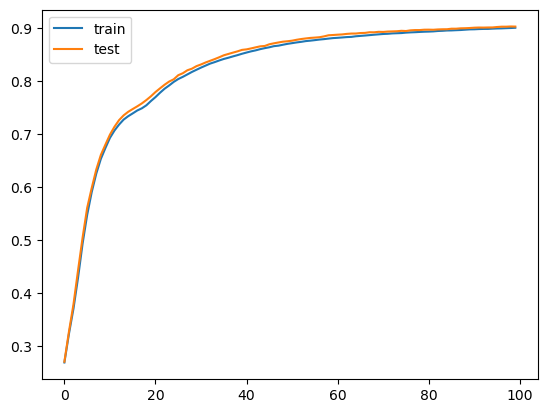

In [22]:
import numpy as np

def plot_acc(train_accuracies, test_accuracies, label1='train', label2='test'):
  x = np.arange(len(train_accuracies))

  plt.plot(x, train_accuracies, label=label1)
  plt.plot(x, test_accuracies, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_accuracies, test_accuracies)